In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import (load_config, seed_everything, calculate_cv_per_class, calculate_d_ratio, calculate_detection_rate, correct_blank,
                       get_low_cv_features, get_high_detection_rate_features, get_high_mz_features)

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Read files 

In [3]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta = sample_meta[sample_meta['batch']==1]

data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat = data_mat[data_mat['sample'].isin(sample_meta['sample'].values.tolist())]

feat_meta = pd.read_csv(config['paths']['feat_meta_path'])

ft_columns = [col for col in data_mat.columns if col.startswith('FT')]

### Correct blanks

In [4]:
# This step subtracts the mean intensity of Blank samples from Bio and QC samples

data_mat[ft_columns] = correct_blank(
    data_mat[ft_columns], sample_meta, sample_classes=['LMU', 'French', 'Dunn', 'QC', 'dQC'], blank_classes=['B']
)

/Users/saadat/Desktop/ml_iso/glycan_analysis/task1/src/utils.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix.loc[samples_meta['class'].isin(sample_classes)] = corrected


### Filters

In [5]:
# filter 1: CV < 0.3 in QC samples
low_cv_features = get_low_cv_features(data_mat, sample_meta, ft_columns, threshold=0.3)
len(low_cv_features)


192

In [6]:
# filter 2: detection rate > 0.7 in bio samples
high_detection_rate_features = get_high_detection_rate_features(data_mat, sample_meta, ft_columns, bio_samples=['LMU', 'French', 'Dunn'], threshold=0.7)
len(high_detection_rate_features)

252

In [7]:
# filter 3: mz > 500
features_in_mass_range = get_high_mz_features(feat_meta, mz_threshold=500)
len(features_in_mass_range)

248

In [8]:
# apply all filters
pass_features = list(set(low_cv_features) & set(high_detection_rate_features) & set(features_in_mass_range))
len(pass_features)

189

In [9]:
# update data_mat and feat_meta
data_mat = data_mat[['sample'] + pass_features]
feat_meta = feat_meta[feat_meta['feature'].isin(pass_features)]

### Checking sample-to-sample variation

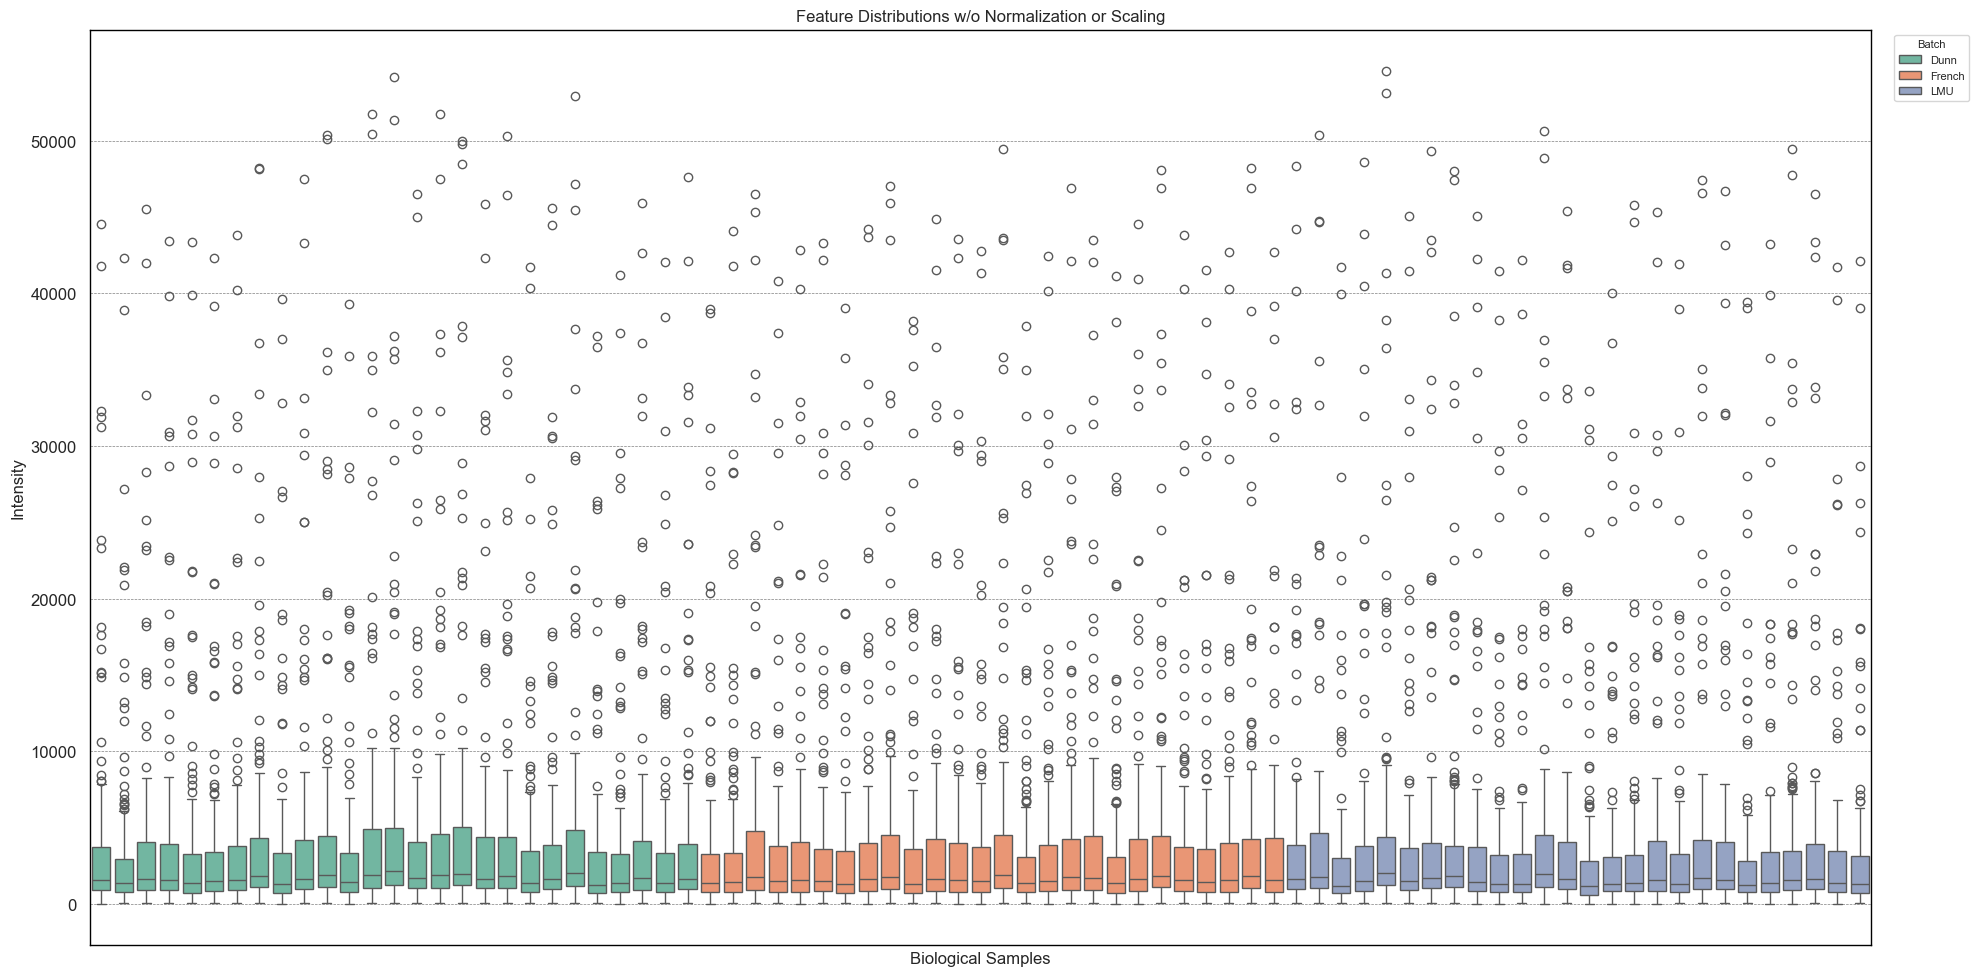

In [10]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(20, 10))
#sns.lineplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', alpha=0.8, palette = 'Set2', linestyle='', err_style='bars', marker='o')
sns.boxplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', palette = 'Set2')
plt.title('Feature Distributions w/o Normalization or Scaling')
plt.xlabel('Biological Samples')
plt.ylabel('Intensity')
plt.xticks(None)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([])  
plt.tight_layout()
plt.show()

In [11]:
# normalize by total intensity
data_mat[pass_features] = data_mat[pass_features].divide(data_mat[pass_features].sum(axis=1), axis=0)

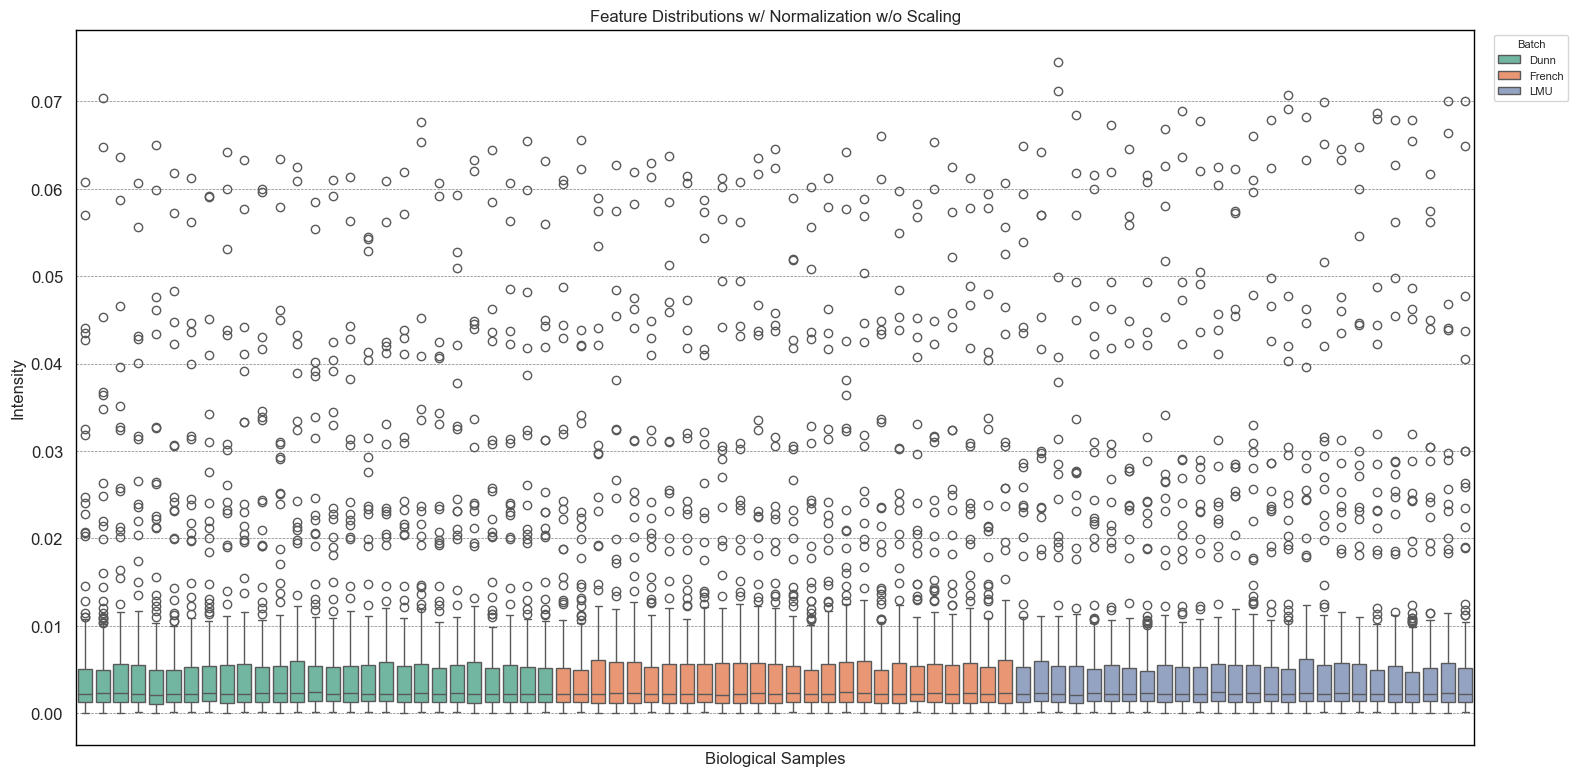

In [12]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(16, 8))
#sns.lineplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', alpha=0.8, palette = 'Set2', linestyle='', err_style='bars', marker='o')
sns.boxplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', palette = 'Set2')
plt.title('Feature Distributions w/ Normalization w/o Scaling')
plt.xlabel('Biological Samples')
plt.ylabel('Intensity')
plt.xticks(None)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([])  
plt.tight_layout()
plt.show()

In [13]:
data_mat[pass_features] = (data_mat[pass_features] - data_mat[pass_features].mean()) / data_mat[pass_features].std()

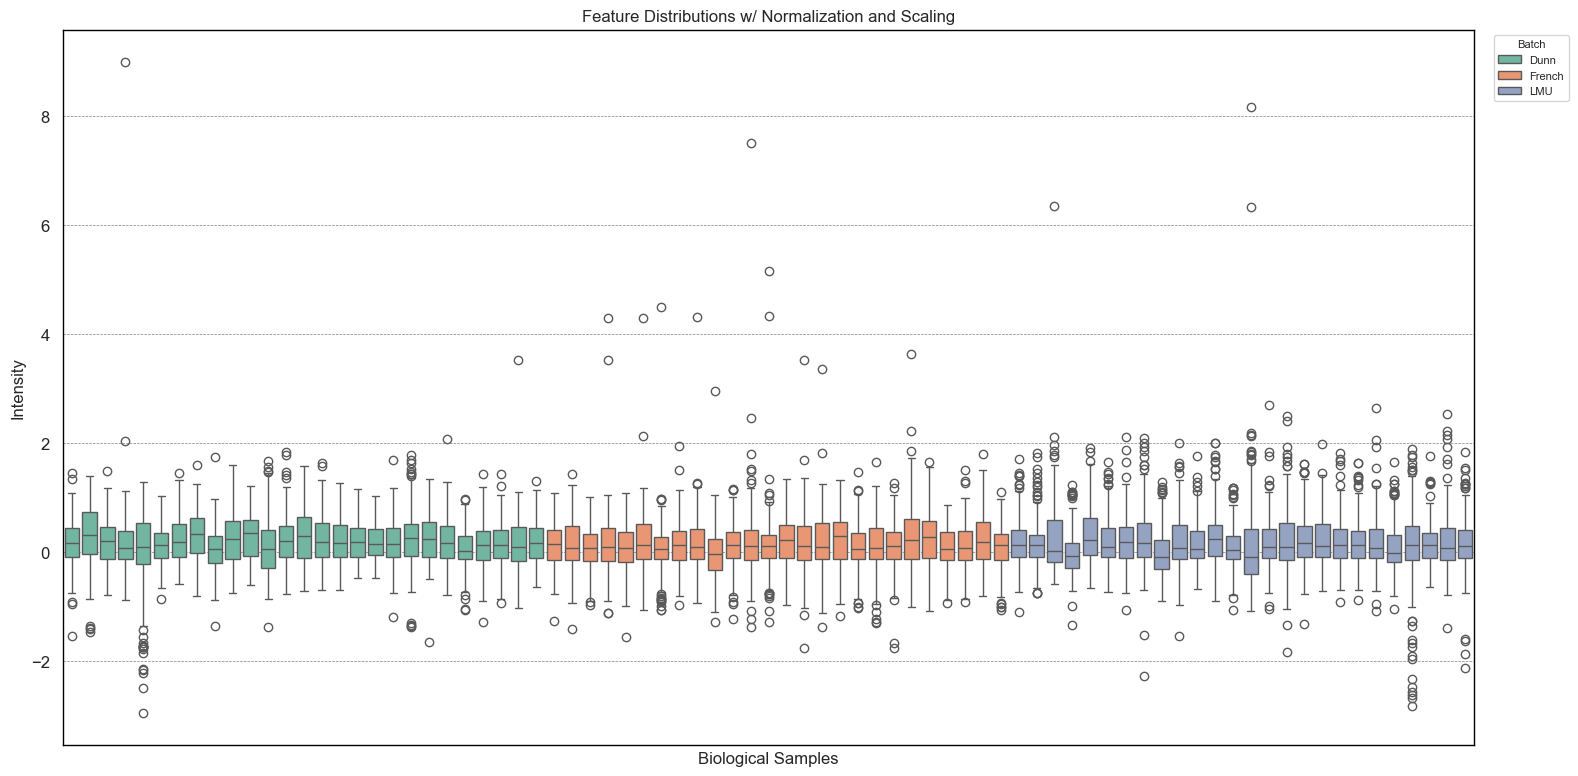

In [14]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(16, 8))
#sns.lineplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', alpha=0.8, palette = 'Set2', linestyle='', err_style='bars', marker='o')
sns.boxplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', palette = 'Set2')
plt.title('Feature Distributions w/ Normalization and Scaling')
plt.xlabel('Biological Samples')
plt.ylabel('Intensity')
plt.xticks(None)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([])  
plt.tight_layout()
plt.show()

In [18]:
bio_ids = sample_meta[sample_meta['class'].isin(['LMU', 'French', 'Dunn'])]['sample'].values.tolist()
data_mat_final = data_mat[data_mat['sample'].isin(bio_ids)].merge(sample_meta[['sample', 'class']], how='left')
data_mat_final.to_csv('../results/misc/data_mat_filter_norm_scale.csv')

,sample,FT-022,FT-191,FT-053,FT-116,FT-198,FT-101,FT-102,FT-060,FT-168,...,FT-077,FT-105,FT-150,FT-041,FT-050,FT-233,FT-189,FT-051,FT-082,class
0,20241106-297-Dunn-1,0.191595,0.339633,0.347268,-0.273663,0.241216,0.085438,0.771563,0.027116,-0.420849,...,0.531341,0.038208,-0.078416,0.701250,0.354811,0.201475,-0.091266,0.666953,-0.099683,Dunn
1,20241106-297-Dunn-10,0.686897,0.230399,0.303049,0.374387,0.596197,0.710663,0.982165,1.390860,-0.149890,...,0.789727,0.566540,-0.200681,1.082912,0.472022,0.681468,-0.082027,1.248885,-0.088120,Dunn
2,20241106-297-Dunn-11,0.106209,0.361677,0.369252,-0.157423,0.571231,0.267205,0.059360,0.141208,-0.133455,...,0.541433,0.150696,-0.281464,0.648077,0.567041,0.198980,-0.090722,-0.334151,-0.089212,Dunn
3,20241106-297-Dunn-12,0.227315,-0.008836,0.162290,-0.874116,0.406250,0.075435,0.002443,-0.447050,-0.168701,...,0.451466,-0.055034,0.025206,0.612356,0.525900,0.581068,-0.093342,2.032357,-0.107220,Dunn
4,20241106-297-Dunn-13,-1.557744,0.096876,0.542979,0.094801,-0.083864,0.363470,-0.944807,-1.742403,-1.221735,...,0.614958,0.228834,-0.047448,1.043331,0.469697,0.705556,-0.090808,1.191893,-0.093901,Dunn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,20241106-297-LMU-5,-0.146463,-0.423669,0.338019,-0.401540,0.350497,0.546191,-0.268084,1.247172,0.023973,...,-0.010463,0.425830,0.170700,-0.330002,-0.545986,0.061787,-0.107405,-0.506484,-0.086095,LMU
75,20241106-297-LMU-6,-2.560506,0.529836,0.947596,0.059798,-1.007010,0.543302,-0.303387,-0.853501,-2.474814,...,0.033292,0.613214,-0.312037,-0.002351,-0.527380,0.425120,-0.097647,-0.199922,-0.077084,LMU
76,20241106-297-LMU-7,0.363117,0.093549,0.777185,0.336642,0.448261,0.146334,-0.357483,0.600551,0.122992,...,0.259386,-0.013281,-0.103345,0.021879,-0.615692,0.247873,-0.104643,-0.111490,-0.112520,LMU
77,20241106-297-LMU-8,-0.109988,0.027654,1.150701,0.061951,0.566876,0.689629,-0.481566,0.039872,0.168600,...,0.016427,0.676340,0.640791,-0.076808,-0.793764,0.486293,-0.107680,0.570311,-0.082047,LMU
